<a href="https://colab.research.google.com/github/HazelvdW/context-framed-listening/blob/main/framed_listening_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Framed Listening: **BERT analyses**
> By **Hazel A. van der Walle** (PhD student, Music, Durham University), October 2025.

This notebook analyses semantic similarity between music-evoked thought (MET)
descriptions to answer: "Does context cue influence METs more than the music itself?"

Analysis approach:
- Works with individual thought descriptions (N=1962) and aggregated documents (called "METdocs")
- Calculates pairwise cosine similarities between all individual thoughts and between METdocs
- Categorises pairs by their stimuli conditions to compare similarity distributions
- Tests whether thoughts are more similar when sharing music vs sharing context

Key comparisons:
1. Same clip + different context VS Different clip + same context
   → Does music or context drive thought similarity?
2. Within vs between genre/context/clip conditions
   → What factors influence semantic coherence in METs?

---

All datasets generated and used for this study are openly available on GitHub https://github.com/HazelvdW/context-framed-listening.

In [1]:
!rm -r context-framed-listening
# Clone the GitHub repository
!git clone https://github.com/HazelvdW/context-framed-listening.git

Cloning into 'context-framed-listening'...
remote: Enumerating objects: 397, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 397 (delta 3), reused 0 (delta 0), pack-reused 384 (from 3)
Receiving objects: 100% (397/397), 125.66 MiB | 15.40 MiB/s, done.
Resolving deltas: 100% (176/176), done.


Refresh files to see **"context-framed-listening"**.


---

## Setup

In [2]:
import pandas as pd
import numpy as np

import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Initialise pretrained BERT model and tokeniser:

In [3]:
print("\nLoading BERT model and tokeniser...")
BERTtokeniser = BertTokenizer.from_pretrained('bert-base-uncased')
BERTmodel = BertModel.from_pretrained('bert-base-uncased')
print("BERT model loaded successfully\n")

def get_bert_embedding(text):
    """Get BERT embedding for a single text document using mean pooling."""
    # Tokenise and encode the text
    inputs = BERTtokeniser(text, return_tensors='pt', padding=True,
                           truncation=True, max_length=512)

    # Get BERT outputs
    with torch.no_grad():
        outputs = BERTmodel(**inputs)

    # Use mean pooling across all tokens
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embedding


Loading BERT model and tokeniser...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


BERT model loaded successfully



Load in the data file "**dataMET_preprocessed.csv**" that contains the preprocessed text data of participants' thought desciptions, generated using the code notebook titled [framed_listening_text_prep](https://github.com/HazelvdW/context-framed-listening/blob/main/framed_listening_text_prep.ipynb)

In [4]:
print("Loading preprocessed MET data...")
dataMETpre = pd.read_csv("/content/context-framed-listening/NLP_outputs/dataMET_preprocessed.csv")

# Use the BERT-appropriate preprocessing column (minimal filtering)
thought_column = 'METdescr_prepLVL1'

print(f"Total individual MET descriptions for analysis: {len(dataMETpre)}")
print(f"Unique clips: {dataMETpre['clip_name'].nunique()}")
print(f"Unique contexts: {dataMETpre['context_word'].nunique()}")
print(f"Unique clip-context pairs: {dataMETpre['clip_context_PAIR'].nunique()}")

Loading preprocessed MET data...
Total individual MET descriptions for analysis: 1962
Unique clips: 16
Unique contexts: 4
Unique clip-context pairs: 64


---
## ANALYSIS AT INDIVIDUAL MET LEVEL

Measuring semantic similarity between indivudal thought descriptions.


### BERT embeddings

Compute BERT embeddings for all individual thoughts:

In [5]:
print("\nComputing BERT embeddings for individual thoughts...")
print("This may take several minutes for ~2000 thoughts...")

embeddings = []
for idx, row in dataMETpre.iterrows():
    text = str(row[thought_column])
    embedding = get_bert_embedding(text)
    embeddings.append(embedding)

    if (idx + 1) % 200 == 0:
        print(f"  Processed {idx + 1}/{len(dataMETpre)} thoughts...")

embeddings = np.array(embeddings)
print(f"\nBERT embeddings shape: {embeddings.shape}")

# Save embeddings for reuse
np.save('/content/context-framed-listening/NLP_outputs/BERT/indvMET_embeddings_BERT.npy',
        embeddings)
print("Embeddings saved")


Computing BERT embeddings for individual thoughts...
This may take several minutes for ~2000 thoughts...
  Processed 200/1962 thoughts...
  Processed 400/1962 thoughts...
  Processed 600/1962 thoughts...
  Processed 800/1962 thoughts...
  Processed 1000/1962 thoughts...
  Processed 1200/1962 thoughts...
  Processed 1400/1962 thoughts...
  Processed 1600/1962 thoughts...
  Processed 1800/1962 thoughts...

BERT embeddings shape: (1962, 768)
Embeddings saved


### Pairwise Cosine Similarity

In [6]:
print("\nCalculating pairwise cosine similarity matrix...")
print(f"This creates a {len(dataMETpre)} x {len(dataMETpre)} matrix...")

cosine_matrix = cosine_similarity(embeddings, embeddings)

# Save full similarity matrix
cosine_df = pd.DataFrame(
    cosine_matrix,
    index=dataMETpre.index,
    columns=dataMETpre.index
)
cosine_df.to_csv('/content/context-framed-listening/NLP_outputs/BERT/indvMET_cosine_matrix_BERT.csv')
print("Cosine similarity matrix saved")


Calculating pairwise cosine similarity matrix...
This creates a 1962 x 1962 matrix...
Cosine similarity matrix saved


### Similarity Values by Condition

In [7]:
print("\nExtracting similarity values for each condition...")

# Initialise storage for similarity measures
similarity_data = {
    'thought_i': [],
    'thought_j': [],
    'similarity': [],
    'same_clip': [],
    'same_context': [],
    'same_genre': [],
    'same_participant': [],
    'condition': []
}

# Extract metadata for efficient comparison
clips = dataMETpre['clip_name'].values
contexts = dataMETpre['context_word'].values
genres = dataMETpre['clip_genre'].values
participants = dataMETpre['participant_id'].values if 'participant_id' in dataMETpre.columns else np.zeros(len(dataMETpre))

# Iterate through upper triangle of similarity matrix (avoid duplicates)
n_thoughts = len(dataMETpre)
total_pairs = (n_thoughts * (n_thoughts - 1)) // 2
print(f"Processing {total_pairs:,} unique thought pairs...")

for i in range(n_thoughts):
    if (i + 1) % 200 == 0:
        print(f"  Processed {i + 1}/{n_thoughts} thoughts...")

    for j in range(i + 1, n_thoughts):
        # Extract similarity value
        sim_value = cosine_matrix[i, j]

        # Determine conditions
        same_clip = clips[i] == clips[j]
        same_context = contexts[i] == contexts[j]
        same_genre = genres[i] == genres[j]
        same_participant = participants[i] == participants[j]

        # Categorize into primary conditions for the research question
        if same_clip and same_context:
            condition = 'sameClip_sameContext'
        elif same_clip and not same_context:
            condition = 'sameClip_diffContext'  # KEY: Music influence
        elif not same_clip and same_context:
            condition = 'diffClip_sameContext'  # KEY: Context influence
        elif not same_clip and not same_context:
            if same_genre:
                condition = 'diffClip_diffContext_sameGenre'
            else:
                condition = 'diffClip_diffContext_diffGenre'

        # Store data
        similarity_data['thought_i'].append(i)
        similarity_data['thought_j'].append(j)
        similarity_data['similarity'].append(sim_value)
        similarity_data['same_clip'].append(same_clip)
        similarity_data['same_context'].append(same_context)
        similarity_data['same_genre'].append(same_genre)
        similarity_data['same_participant'].append(same_participant)
        similarity_data['condition'].append(condition)

# Create DataFrame
sim_df = pd.DataFrame(similarity_data)
sim_df.to_csv('/content/context-framed-listening/NLP_outputs/BERT/indvMET_similarity_by_condition_BERT.csv',
              index=False)

print("\nSimilarity measures extracted")
print("\nCondition summary:")
print(sim_df.groupby('condition')['similarity'].agg(['count', 'mean', 'std', 'min', 'max']))



Extracting similarity values for each condition...
Processing 1,923,741 unique thought pairs...
  Processed 200/1962 thoughts...
  Processed 400/1962 thoughts...
  Processed 600/1962 thoughts...
  Processed 800/1962 thoughts...
  Processed 1000/1962 thoughts...
  Processed 1200/1962 thoughts...
  Processed 1400/1962 thoughts...
  Processed 1600/1962 thoughts...
  Processed 1800/1962 thoughts...

Similarity measures extracted

Condition summary:
                                  count      mean       std       min  \
condition                                                               
diffClip_diffContext_diffGenre  1082516  0.642640  0.103176  0.049132   
diffClip_diffContext_sameGenre   270501  0.645706  0.103808  0.060095   
diffClip_sameContext             450875  0.645514  0.103856  0.066669   
sameClip_diffContext              90474  0.650263  0.104820  0.075124   
sameClip_sameContext              29375  0.653549  0.106365  0.092366   

                                     m

---
### STATISTICAL ANALYSES

1. PRIMARY RESEARCH QUESTION: Music vs Context Influence
2. Genre Effects
3. Context Specificity
4. Music Specificity
5. BASELINE COMPARISON: Total shared features
6. OMNIBUS TEST: Overall condition differences
7. Effect Size Ranking

In [8]:
def compare_conditions(df, cond1, cond2, label1, label2):
    """Compare two conditions with t-test and effect size."""
    data1 = df[df['condition'] == cond1]['similarity']
    data2 = df[df['condition'] == cond2]['similarity']

    t_stat, p_value = stats.ttest_ind(data1, data2)

    # Cohen's d
    pooled_std = np.sqrt((data1.std()**2 + data2.std()**2) / 2)
    effect_size = (data1.mean() - data2.mean()) / pooled_std

    if p_value < 0.001:
        sig_str = "***"
    elif p_value < 0.01:
        sig_str = "**"
    elif p_value < 0.05:
        sig_str = "*"
    else:
        sig_str = "n.s."

    return {
        'comparison': f"{label1} vs {label2}",
        'mean1': data1.mean(),
        'mean2': data2.mean(),
        'diff': data1.mean() - data2.mean(),
        't': t_stat,
        'p': p_value,
        'sig': sig_str,
        'd': effect_size,
        'n1': len(data1),
        'n2': len(data2)
    }

print("\n" + "="*70)
print("COMPREHENSIVE STATISTICAL ANALYSES")
print("="*70)

# Store all comparison results
comparisons = []


# 1. PRIMARY RESEARCH QUESTION: Music vs Context Influence
# ----------------------------------------------------------------------------
print("\n1. PRIMARY QUESTION: Music vs Context Influence")
print("-" * 70)

comp = compare_conditions(
    sim_df,
    'sameClip_diffContext',
    'diffClip_sameContext',
    'Same Music, Diff Context',
    'Diff Music, Same Context'
)
comparisons.append(comp)

print(f"\nSame music, different context: M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Different music, same context: M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"Difference: {comp['diff']:.4f}")
print(f"t({comp['n1'] + comp['n2'] - 2}) = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}")
print(f"Cohen's d = {comp['d']:.3f}")

if comp['mean1'] > comp['mean2']:
    print("\n→ MUSIC drives thought similarity MORE than context")
else:
    print("\n→ CONTEXT drives thought similarity MORE than music")


# 2. GENRE EFFECTS
# ----------------------------------------------------------------------------
print("\n\n2. GENRE EFFECTS")
print("-" * 70)

# Within-genre vs between-genre (when everything else differs)
comp = compare_conditions(
    sim_df,
    'diffClip_diffContext_sameGenre',
    'diffClip_diffContext_diffGenre',
    'Different everything, Same Genre',
    'Different everything, Different Genre'
)
comparisons.append(comp)

print(f"\nSame genre (diff clip & context): M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Different genre (diff clip & context): M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"t = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}, d = {comp['d']:.3f}")

if comp['sig'] != 'n.s.':
    print("\n→ Genre creates semantic coherence even across different clips and contexts")
else:
    print("\n→ Genre does NOT significantly affect thought similarity")


# 3. CONTEXT SPECIFICITY
# ----------------------------------------------------------------------------
print("\n\n3. CONTEXT SPECIFICITY: How much does context alone matter?")
print("-" * 70)

# Same context effects at different levels
same_context_same_clip = sim_df[sim_df['condition'] == 'sameClip_sameContext']['similarity']
same_context_diff_clip = sim_df[sim_df['condition'] == 'diffClip_sameContext']['similarity']

comp = compare_conditions(
    sim_df,
    'sameClip_sameContext',
    'diffClip_sameContext',
    'Same Context & Same Clip',
    'Same Context, Diff Clip'
)
comparisons.append(comp)

print(f"\nSame context + same clip: M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Same context, different clip: M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"t = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}, d = {comp['d']:.3f}")

print("\n→ This shows whether identical stimuli create MORE similarity than just shared context")


# 4. MUSIC SPECIFICITY
# ----------------------------------------------------------------------------
print("\n\n4. MUSIC SPECIFICITY: How much does the specific clip alone matter?")
print("-" * 70)

comp = compare_conditions(
    sim_df,
    'sameClip_sameContext',
    'sameClip_diffContext',
    'Same Clip & Same Context',
    'Same Clip, Diff Context'
)
comparisons.append(comp)

print(f"\nSame clip + same context: M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Same clip, different context: M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"t = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}, d = {comp['d']:.3f}")

print("\n→ This shows whether identical stimuli create MORE similarity than just shared music")


# 5. BASELINE COMPARISON: Total shared features
# ----------------------------------------------------------------------------
print("\n\n5. BASELINE COMPARISONS")
print("-" * 70)

# Everything same vs music-only same
comp = compare_conditions(
    sim_df,
    'sameClip_sameContext',
    'sameClip_diffContext',
    'Everything Same',
    'Only Music Same'
)
print(f"\nEverything same vs Only music same:")
print(f"  M_same={comp['mean1']:.4f}, M_music={comp['mean2']:.4f}")
print(f"  t = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}, d = {comp['d']:.3f}")

# Everything same vs context-only same
comp = compare_conditions(
    sim_df,
    'sameClip_sameContext',
    'diffClip_sameContext',
    'Everything Same',
    'Only Context Same'
)
print(f"\nEverything same vs Only context same:")
print(f"  M_same={comp['mean1']:.4f}, M_context={comp['mean2']:.4f}")
print(f"  t = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}, d = {comp['d']:.3f}")

# Everything different (genre match vs no match)
all_diff = sim_df[sim_df['condition'].str.contains('diff_clip_diff_context')]
print(f"\nEverything different (baseline): M={all_diff['similarity'].mean():.4f} (N={len(all_diff)})")


# 6. OMNIBUS TEST: Overall condition differences
# ----------------------------------------------------------------------------
print("\n\n6. OMNIBUS TEST: Do conditions differ overall?")
print("-" * 70)

# One-way ANOVA across all conditions
conditions = sim_df['condition'].unique()
groups = [sim_df[sim_df['condition'] == cond]['similarity'] for cond in conditions]
f_stat, p_anova = stats.f_oneway(*groups)

print(f"\nOne-way ANOVA across all {len(conditions)} conditions:")
print(f"F({len(conditions)-1}, {len(sim_df)-len(conditions)}) = {f_stat:.3f}, p = {p_anova:.4e}")

if p_anova < 0.001:
    print("\n→ Conditions are HIGHLY significantly different overall")
else:
    print("\n→ Conditions show significant differences" if p_anova < 0.05 else "→ No significant differences")


# 7. EFFECT SIZE RANKING
# ----------------------------------------------------------------------------

print("\n\n7. EFFECT SIZE RANKING: Which comparisons matter most?")
print("-" * 70)

# Calculate all pairwise effect sizes
condition_means = sim_df.groupby('condition')['similarity'].agg(['mean', 'std', 'count'])
condition_means = condition_means.sort_values('mean', ascending=False)

print("\nCondition means (ranked):")
print(condition_means)

# Save comparison results
comparisons_df = pd.DataFrame(comparisons)
comparisons_df = comparisons_df.sort_values('d', key=abs, ascending=False)
comparisons_df.to_csv('/content/context-framed-listening/NLP_outputs/BERT/indvMET_statistical_comparisons_BERT.csv', index=False)

print("\n\nKey comparisons ranked by effect size:")
print(comparisons_df[['comparison', 'diff', 'd', 'p', 'sig']])


COMPREHENSIVE STATISTICAL ANALYSES

1. PRIMARY QUESTION: Music vs Context Influence
----------------------------------------------------------------------

Same music, different context: M=0.6503 (N=90474)
Different music, same context: M=0.6455 (N=450875)
Difference: 0.0047
t(541347) = 12.531, p = 0.0000 ***
Cohen's d = 0.046

→ MUSIC drives thought similarity MORE than context


2. GENRE EFFECTS
----------------------------------------------------------------------

Same genre (diff clip & context): M=0.6457 (N=270501)
Different genre (diff clip & context): M=0.6426 (N=1082516)
t = 13.807, p = 0.0000 ***, d = 0.030

→ Genre creates semantic coherence even across different clips and contexts


3. CONTEXT SPECIFICITY: How much does context alone matter?
----------------------------------------------------------------------

Same context + same clip: M=0.6535 (N=29375)
Same context, different clip: M=0.6455 (N=450875)
t = 12.829, p = 0.0000 ***, d = 0.076

→ This shows whether identica

### Visualisations

1. PRIMARY COMPARISON: Music vs Context
2. ALL CONDITIONS comparison
3. Bar plot with means and 95% CI
4. Distribution comparison histogram (Music vs Context)
5. HIERARCHICAL comparison showing all levels
6. Genre effects visualization
7. Heatmap showing mean similarities between conditions


Generating visualisations...


/tmp/ipython-input-4139798692.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Same Music\nDifferent Context', 'Different Music\nSame Context'])


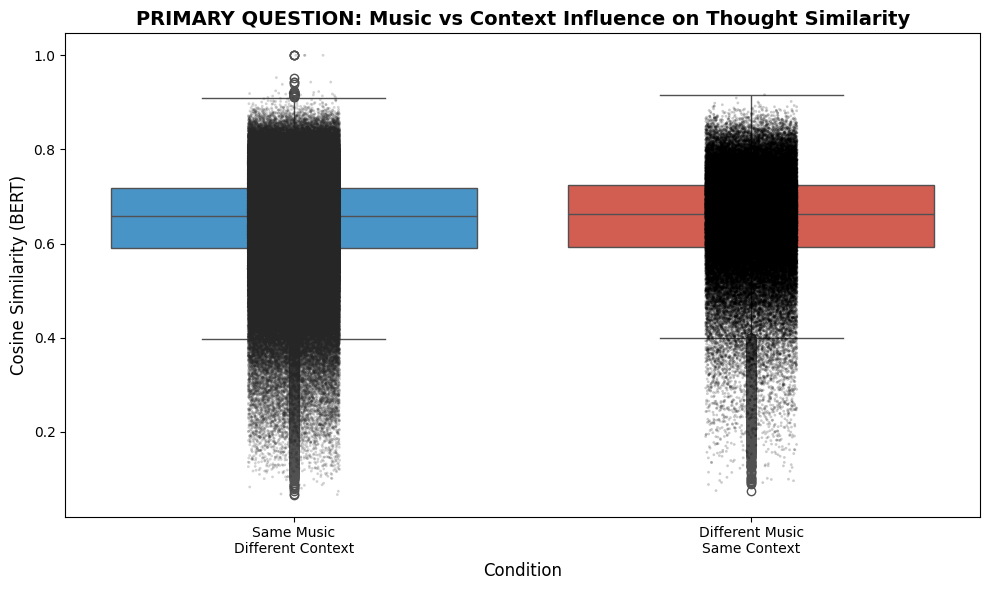

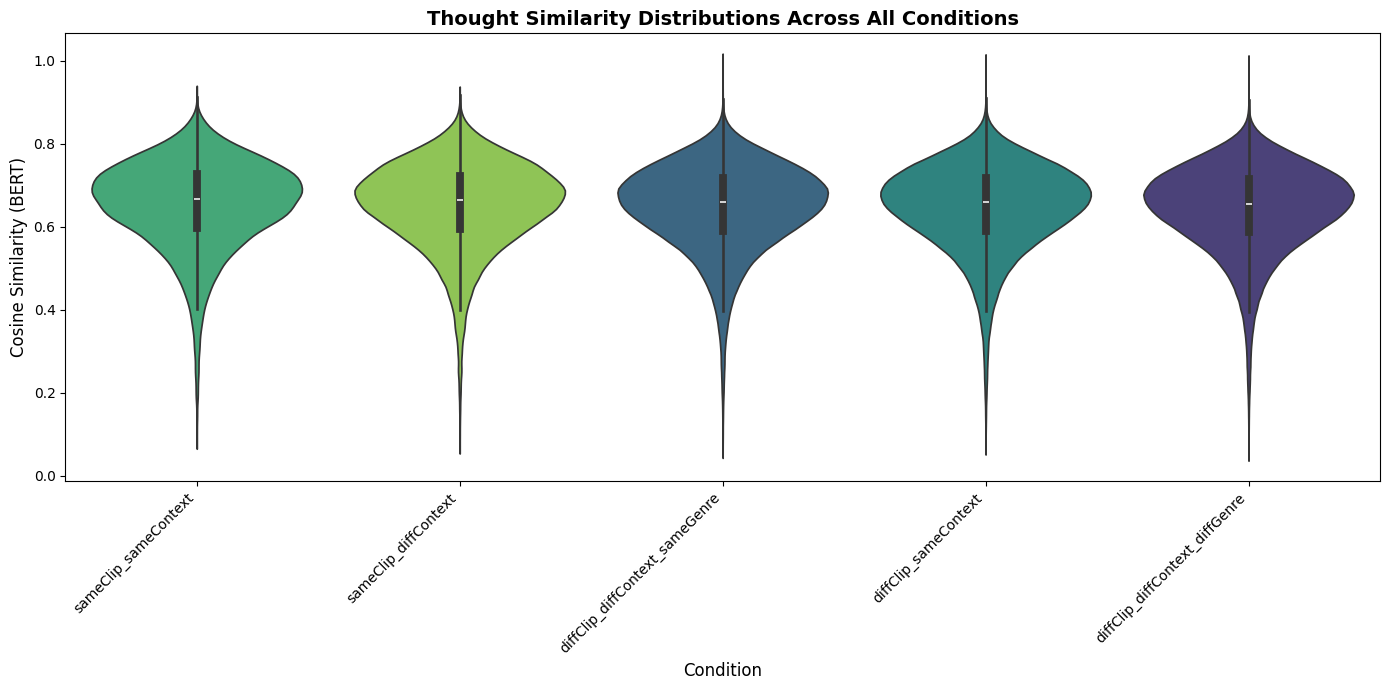

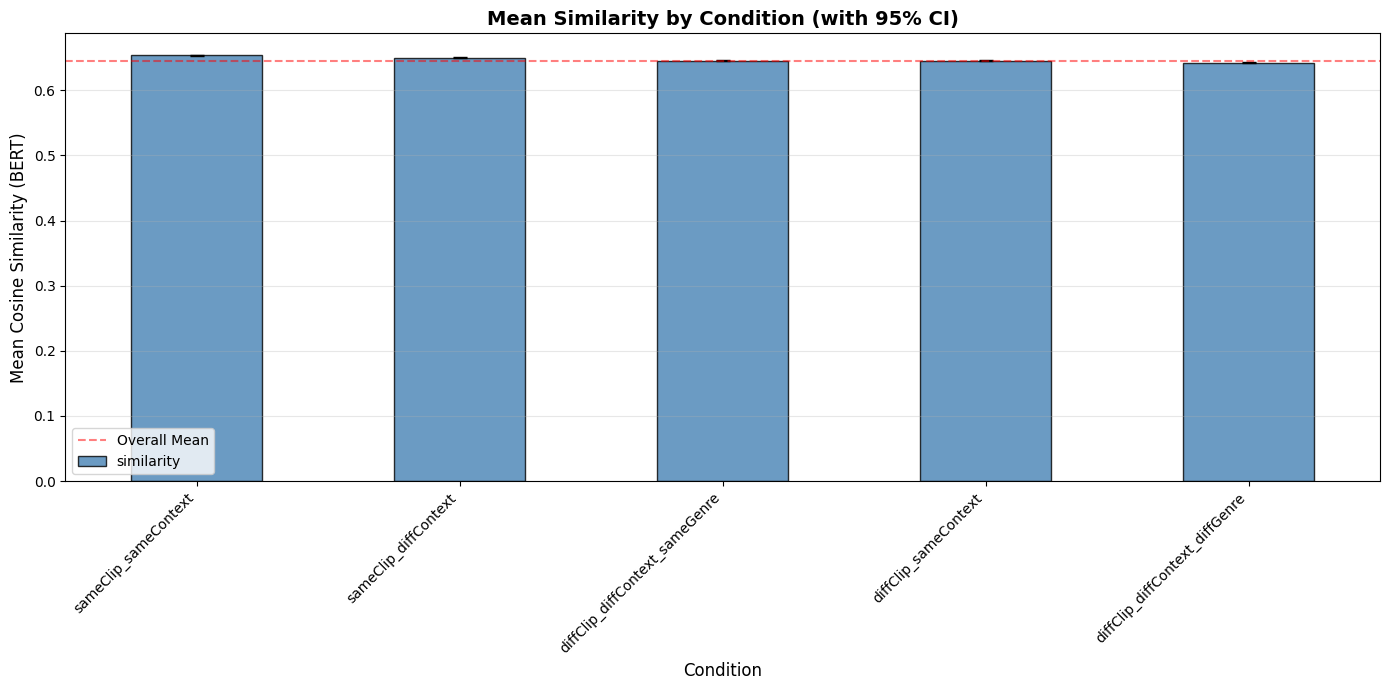

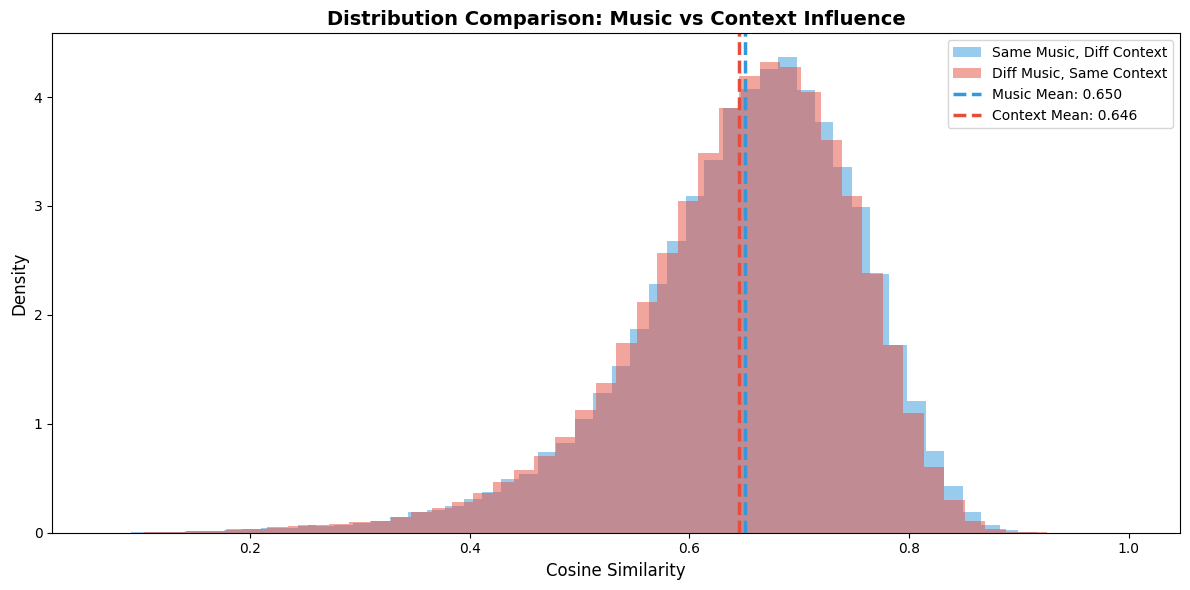

/tmp/ipython-input-4139798692.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=0, ha='center')


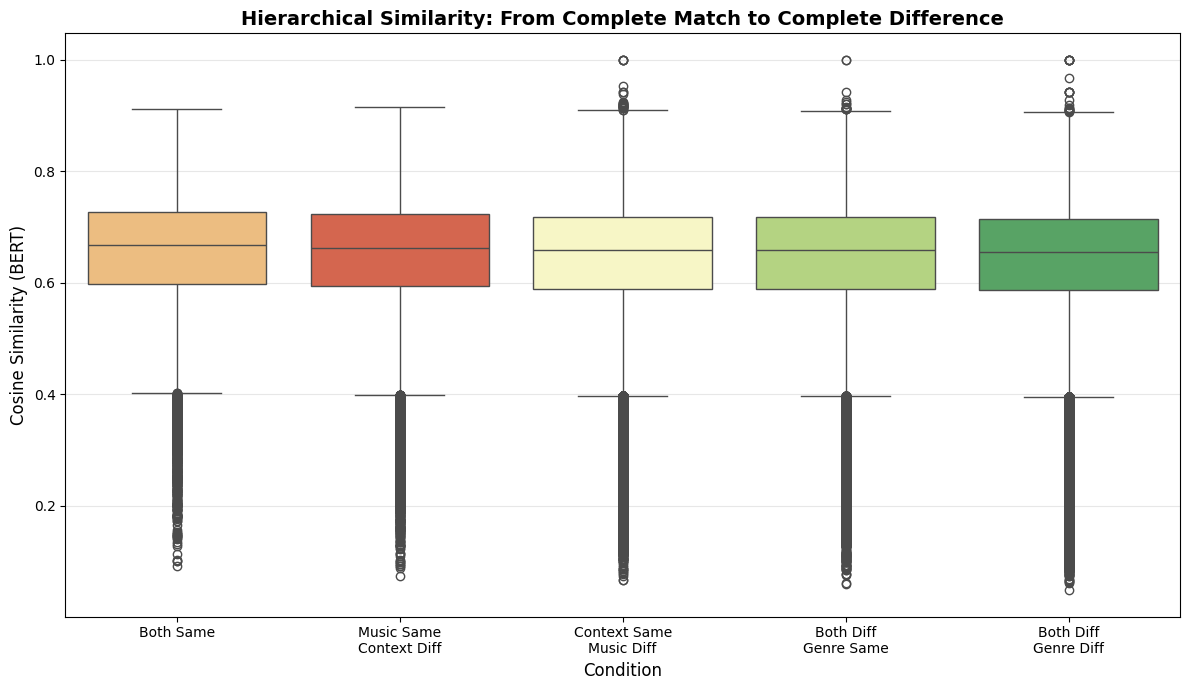

/tmp/ipython-input-4139798692.py:118: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Same Genre', 'Different Genre'])


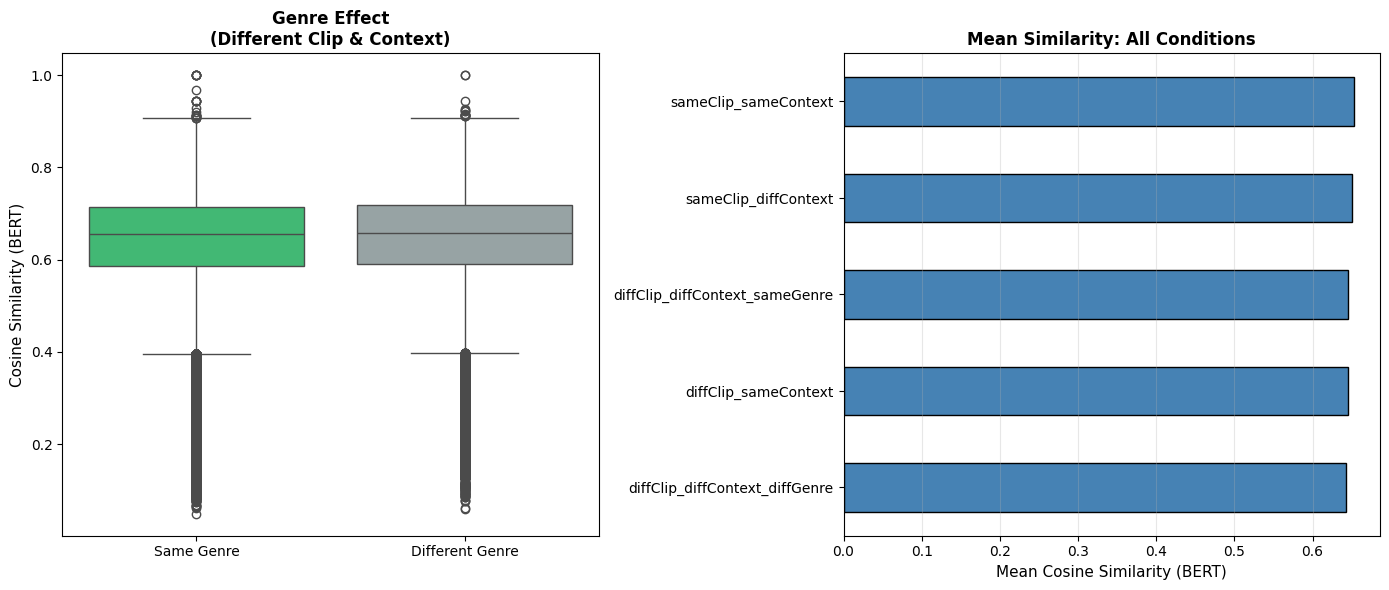

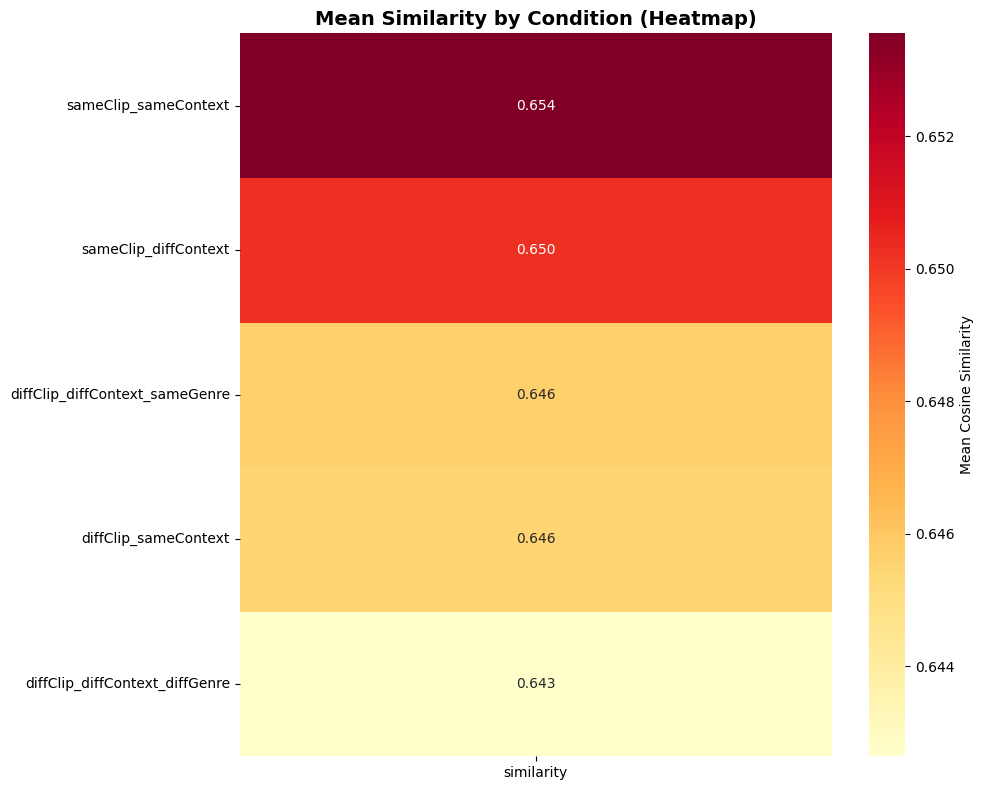

In [9]:
print("\nGenerating visualisations...")

# Get data for key conditions
music_driven = sim_df[sim_df['condition'] == 'sameClip_diffContext']['similarity']
context_driven = sim_df[sim_df['condition'] == 'diffClip_sameContext']['similarity']
same_both = sim_df[sim_df['condition'] == 'sameClip_sameContext']['similarity']
diff_both_same_genre = sim_df[sim_df['condition'] == 'diffClip_diffContext_sameGenre']['similarity']
diff_both_diff_genre = sim_df[sim_df['condition'] == 'diffClip_diffContext_diffGenre']['similarity']

# 1. PRIMARY COMPARISON: Music vs Context
fig, ax = plt.subplots(figsize=(10, 6))
comparison_data = sim_df[sim_df['condition'].isin(['sameClip_diffContext', 'diffClip_sameContext'])]
sns.boxplot(data=comparison_data, x='condition', y='similarity', ax=ax,
            hue='condition', palette=['#3498db', '#e74c3c'])
sns.stripplot(data=comparison_data, x='condition', y='similarity', ax=ax,
              hue='condition', palette='dark:black', alpha=0.2, size=2)
ax.set_title('PRIMARY QUESTION: Music vs Context Influence on Thought Similarity',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Cosine Similarity (BERT)', fontsize=12)
ax.set_xticklabels(['Same Music\nDifferent Context', 'Different Music\nSame Context'])
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/indvMET_01_music_vs_context_boxplot_BERT.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 2. ALL CONDITIONS comparison
fig, ax = plt.subplots(figsize=(14, 7))
condition_order = sim_df.groupby('condition')['similarity'].mean().sort_values(ascending=False).index
sns.violinplot(data=sim_df, x='condition', y='similarity', ax=ax, order=condition_order,
               hue='condition', palette='viridis')
ax.set_title('Thought Similarity Distributions Across All Conditions', fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Cosine Similarity (BERT)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/indvMET_02_all_conditions_violin_BERT.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 3. Bar plot with means and 95% CI
fig, ax = plt.subplots(figsize=(14, 7))
means = sim_df.groupby('condition')['similarity'].mean().sort_values(ascending=False)
sems = sim_df.groupby('condition')['similarity'].sem()
ci95 = sems * 1.96  # 95% confidence interval

means.plot(kind='bar', ax=ax, yerr=ci95, capsize=5, color='steelblue',
           edgecolor='black', alpha=0.8, error_kw={'linewidth': 2})
ax.set_title('Mean Similarity by Condition (with 95% CI)', fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Mean Cosine Similarity (BERT)', fontsize=12)
ax.set_xticklabels(means.index, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=sim_df['similarity'].mean(), color='red', linestyle='--',
           alpha=0.5, label='Overall Mean')
ax.legend()
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/indvMET_03_condition_means_barplot_BERT.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 4. Distribution comparison histogram (Music vs Context)
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(music_driven, bins=50, alpha=0.5, label='Same Music, Diff Context', color='#3498db', density=True)
ax.hist(context_driven, bins=50, alpha=0.5, label='Diff Music, Same Context', color='#e74c3c', density=True)
ax.axvline(music_driven.mean(), color='#3498db', linestyle='--', linewidth=2.5,
           label=f'Music Mean: {music_driven.mean():.3f}')
ax.axvline(context_driven.mean(), color='#e74c3c', linestyle='--', linewidth=2.5,
           label=f'Context Mean: {context_driven.mean():.3f}')
ax.set_xlabel('Cosine Similarity', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Distribution Comparison: Music vs Context Influence', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/indvMET_04_music_vs_context_histogram_BERT.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 5. HIERARCHICAL comparison showing all levels
fig, ax = plt.subplots(figsize=(12, 7))
hierarchical_data = sim_df[sim_df['condition'].isin([
    'sameClip_sameContext',
    'sameClip_diffContext',
    'diffClip_sameContext',
    'diffClip_diffContext_sameGenre',
    'diffClip_diffContext_diffGenre'
])]

order = ['sameClip_sameContext', 'sameClip_diffContext', 'diffClip_sameContext',
         'diffClip_diffContext_sameGenre', 'diffClip_diffContext_diffGenre']
labels = ['Both Same', 'Music Same\nContext Diff', 'Context Same\nMusic Diff',
          'Both Diff\nGenre Same', 'Both Diff\nGenre Diff']

sns.boxplot(data=hierarchical_data, x='condition', y='similarity', ax=ax,
            order=order, hue='condition', palette='RdYlGn_r')
ax.set_xticklabels(labels, rotation=0, ha='center')
ax.set_title('Hierarchical Similarity: From Complete Match to Complete Difference',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Cosine Similarity (BERT)', fontsize=12)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/indvMET_05_hierarchical_comparison_BERT.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 6. Genre effects visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Genre effect when everything else differs
genre_comparison = sim_df[sim_df['condition'].isin([
    'diffClip_diffContext_sameGenre',
    'diffClip_diffContext_diffGenre'
])]
sns.boxplot(data=genre_comparison, x='condition', y='similarity', ax=axes[0],
            hue='condition', palette=['#2ecc71', '#95a5a6'])
axes[0].set_title('Genre Effect\n(Different Clip & Context)', fontsize=12, fontweight='bold')
axes[0].set_xticklabels(['Same Genre', 'Different Genre'])
axes[0].set_ylabel('Cosine Similarity (BERT)', fontsize=11)
axes[0].set_xlabel('')

# Show all conditions side by side
all_conditions_means = sim_df.groupby('condition')['similarity'].mean()
all_conditions_means.sort_values(ascending=True).plot(kind='barh', ax=axes[1],
                                                       color='steelblue', edgecolor='black')
axes[1].set_title('Mean Similarity: All Conditions', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Mean Cosine Similarity (BERT)', fontsize=11)
axes[1].set_ylabel('')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/indvMET_06_genre_effects_summary_BERT.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 7. Heatmap showing mean similarities between conditions
fig, ax = plt.subplots(figsize=(10, 8))
condition_pivot = sim_df.pivot_table(values='similarity',
                                      index='condition',
                                      aggfunc='mean').sort_values('similarity', ascending=False)
sns.heatmap(condition_pivot, annot=True, fmt='.3f', cmap='YlOrRd',
            cbar_kws={'label': 'Mean Cosine Similarity'}, ax=ax)
ax.set_title('Mean Similarity by Condition (Heatmap)', fontsize=14, fontweight='bold')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/indvMET_07_condition_heatmap_BERT.png',
            dpi=300, bbox_inches='tight')
plt.show()


---
### SUMMARY

In [10]:
print("\n" + "-"*70)
print("ANALYSIS COMPLETE")
print("-"*70)

print("\nOutput files saved:")
print("\n  Data files:")
print("    - indvMET_embeddings_BERT.npy")
print("    - indvMET_cosine_matrix_BERT.csv")
print("    - indvMET_similarity_by_condition_BERT.csv")
print("    - indvMET_statistical_comparisons_BERT.csv")

print("\n  Visualisations:")
print("    - indvMET_01_music_vs_context_boxplot_BERT.png")
print("    - indvMET_02_all_conditions_violin_BERT.png")
print("    - indvMET_03_condition_means_barplot_BERT.png")
print("    - indvMET_04_music_vs_context_histogram_BERT.png")
print("    - indvMET_05_hierarchical_comparison_BERT.png")
print("    - indvMET_06_genre_effects_summary_BERT.png")
print("    - indvMET_07_condition_heatmap_BERT.png")

print("\n" + "-"*70)
print("KEY FINDINGS SUMMARY")
print("-"*70)

# Get the primary comparison again for summary
music_driven_summary = sim_df[sim_df['condition'] == 'sameClip_diffContext']['similarity']
context_driven_summary = sim_df[sim_df['condition'] == 'diffClip_sameContext']['similarity']
diff = music_driven_summary.mean() - context_driven_summary.mean()
t_stat, p_value = stats.ttest_ind(music_driven_summary, context_driven_summary)
effect_size = diff / np.sqrt((music_driven_summary.std()**2 + context_driven_summary.std()**2) / 2)

print("\n1. PRIMARY RESEARCH QUESTION: Music vs Context")
if abs(diff) < 0.01:
    print(f"   → Music and context have EQUIVALENT influence (d={effect_size:.3f})")
elif music_driven_summary.mean() > context_driven_summary.mean():
    print(f"   → MUSIC drives thought similarity MORE than context")
    print(f"   → Difference: {diff:.4f} (d={effect_size:.3f}, p={p_value:.4f})")
else:
    print(f"   → CONTEXT drives thought similarity MORE than music")
    print(f"   → Difference: {abs(diff):.4f} (d={abs(effect_size):.3f}, p={p_value:.4f})")

# Genre effects
same_genre = sim_df[sim_df['condition'] == 'diffClip_diffContext_sameGenre']['similarity'].mean()
diff_genre = sim_df[sim_df['condition'] == 'diffClip_diffContext_diffGenre']['similarity'].mean()
print(f"\n2. GENRE EFFECTS")
print(f"   → Same genre: M={same_genre:.4f}")
print(f"   → Different genre: M={diff_genre:.4f}")
print(f"   → Difference: {same_genre - diff_genre:.4f}")

# Baseline
same_both = sim_df[sim_df['condition'] == 'sameClip_sameContext']['similarity'].mean()
print(f"\n3. BASELINE (identical stimuli): M={same_both:.4f}")

print("\n" + "~"*70)


----------------------------------------------------------------------
ANALYSIS COMPLETE
----------------------------------------------------------------------

Output files saved:

  Data files:
    - indvMET_embeddings_BERT.npy
    - indvMET_cosine_matrix_BERT.csv
    - indvMET_similarity_by_condition_BERT.csv
    - indvMET_statistical_comparisons_BERT.csv

  Visualisations:
    - indvMET_01_music_vs_context_boxplot_BERT.png
    - indvMET_02_all_conditions_violin_BERT.png
    - indvMET_03_condition_means_barplot_BERT.png
    - indvMET_04_music_vs_context_histogram_BERT.png
    - indvMET_05_hierarchical_comparison_BERT.png
    - indvMET_06_genre_effects_summary_BERT.png
    - indvMET_07_condition_heatmap_BERT.png

----------------------------------------------------------------------
KEY FINDINGS SUMMARY
----------------------------------------------------------------------

1. PRIMARY RESEARCH QUESTION: Music vs Context
   → Music and context have EQUIVALENT influence (d=0.046)

2. 

---
## ANALYSIS AT COMBINED METdoc LEVEL

Measuring semantic similarity between agregated representations of conditions.

This is a complementary analysis to the individual MET level analyses above.
It aggregates thoughts into documents by clip-context pairs to examine condition-level semantic profiles. This is useful for comparison but the individual-level analysis is the primary approach for hypothesis testing.

Purpose: Compare semantic profiles at the document/condition level
- Each document = all thoughts from one clip-context pairing
- Shows overall semantic "signature" of each condition
- Useful for exploratory visualisation and pattern detection

In [11]:
print("Loading aggregated METdocs...")
# Load the pre-aggregated METdocs file (clip-context level)
METdocs = pd.read_csv('/content/context-framed-listening/NLP_outputs/METdocsLVL1.csv')

# Use the BERT-appropriate preprocessing column
text_column = 'METdescr_prepLVL1'

print(f"Total METdocs (clip-context pairs): {len(METdocs)}")
print(f"Unique clips: {METdocs['clip_name'].nunique()}")
print(f"Unique contexts: {METdocs['context_word'].nunique()}")

Loading aggregated METdocs...
Total METdocs (clip-context pairs): 64
Unique clips: 16
Unique contexts: 4


### BERT embeddings

In [12]:
print("\nComputing BERT embeddings for aggregated METdocs...")

bert_embeddings = []
for idx, row in METdocs.iterrows():
    text = str(row[text_column])
    embedding = get_bert_embedding(text)
    bert_embeddings.append(embedding)

    if (idx + 1) % 10 == 0:
        print(f"  Processed {idx + 1}/{len(METdocs)} documents...")

bert_embeddings = np.array(bert_embeddings)
print(f"\nBERT embeddings shape: {bert_embeddings.shape}")

# Save embeddings
np.save('/content/context-framed-listening/NLP_outputs/BERT/METdocs_embeddings_BERT.npy',
        bert_embeddings)


Computing BERT embeddings for aggregated METdocs...
  Processed 10/64 documents...
  Processed 20/64 documents...
  Processed 30/64 documents...
  Processed 40/64 documents...
  Processed 50/64 documents...
  Processed 60/64 documents...

BERT embeddings shape: (64, 768)


### Cosine Similarity Matrix


Calculating cosine similarity matrix...

BERT Cosine Similarity Matrix (METdocs level):


ClipContext_pair,BAR-80s_LOW_02,BAR-80s_LOW_06,BAR-80s_MED_08,BAR-80s_MED_13,BAR-Ele_LOW_09,BAR-Ele_LOW_14,BAR-Ele_MED_19,BAR-Ele_MED_20,BAR-Jaz_LOW_19,BAR-Jaz_LOW_21,...,VIDEOGAME-Ele_MED_19,VIDEOGAME-Ele_MED_20,VIDEOGAME-Jaz_LOW_19,VIDEOGAME-Jaz_LOW_21,VIDEOGAME-Jaz_MED_02,VIDEOGAME-Jaz_MED_07,VIDEOGAME-Met_LOW_09,VIDEOGAME-Met_LOW_14,VIDEOGAME-Met_MED_19,VIDEOGAME-Met_MED_20
ClipContext_pair,,,,,,,,,,,,,,,,,,,,,
BAR-80s_LOW_02,1.000000,0.967506,0.962781,0.970385,0.949739,0.960431,0.978360,0.979496,0.962709,0.971613,...,0.961807,0.971428,0.948175,0.966183,0.976479,0.975517,0.946758,0.933002,0.929713,0.949207
BAR-80s_LOW_06,0.967506,1.000000,0.975497,0.960470,0.952239,0.963366,0.966954,0.962764,0.957598,0.971124,...,0.947300,0.951824,0.945619,0.952785,0.963009,0.962407,0.943107,0.924805,0.913748,0.939453
BAR-80s_MED_08,0.962781,0.975497,1.000000,0.966724,0.969688,0.974097,0.968328,0.957603,0.975788,0.980342,...,0.952883,0.958256,0.955702,0.966852,0.970963,0.965861,0.956647,0.940084,0.930537,0.948314
BAR-80s_MED_13,0.970385,0.960470,0.966724,0.999999,0.963705,0.972851,0.969155,0.960751,0.969782,0.974669,...,0.960157,0.977242,0.974350,0.975700,0.967006,0.969166,0.959002,0.955864,0.952665,0.966205
BAR-Ele_LOW_09,0.949739,0.952239,0.969688,0.963705,1.000000,0.975651,0.963649,0.950141,0.968844,0.968702,...,0.957238,0.963930,0.964545,0.962923,0.960796,0.952454,0.971494,0.962510,0.955122,0.965784


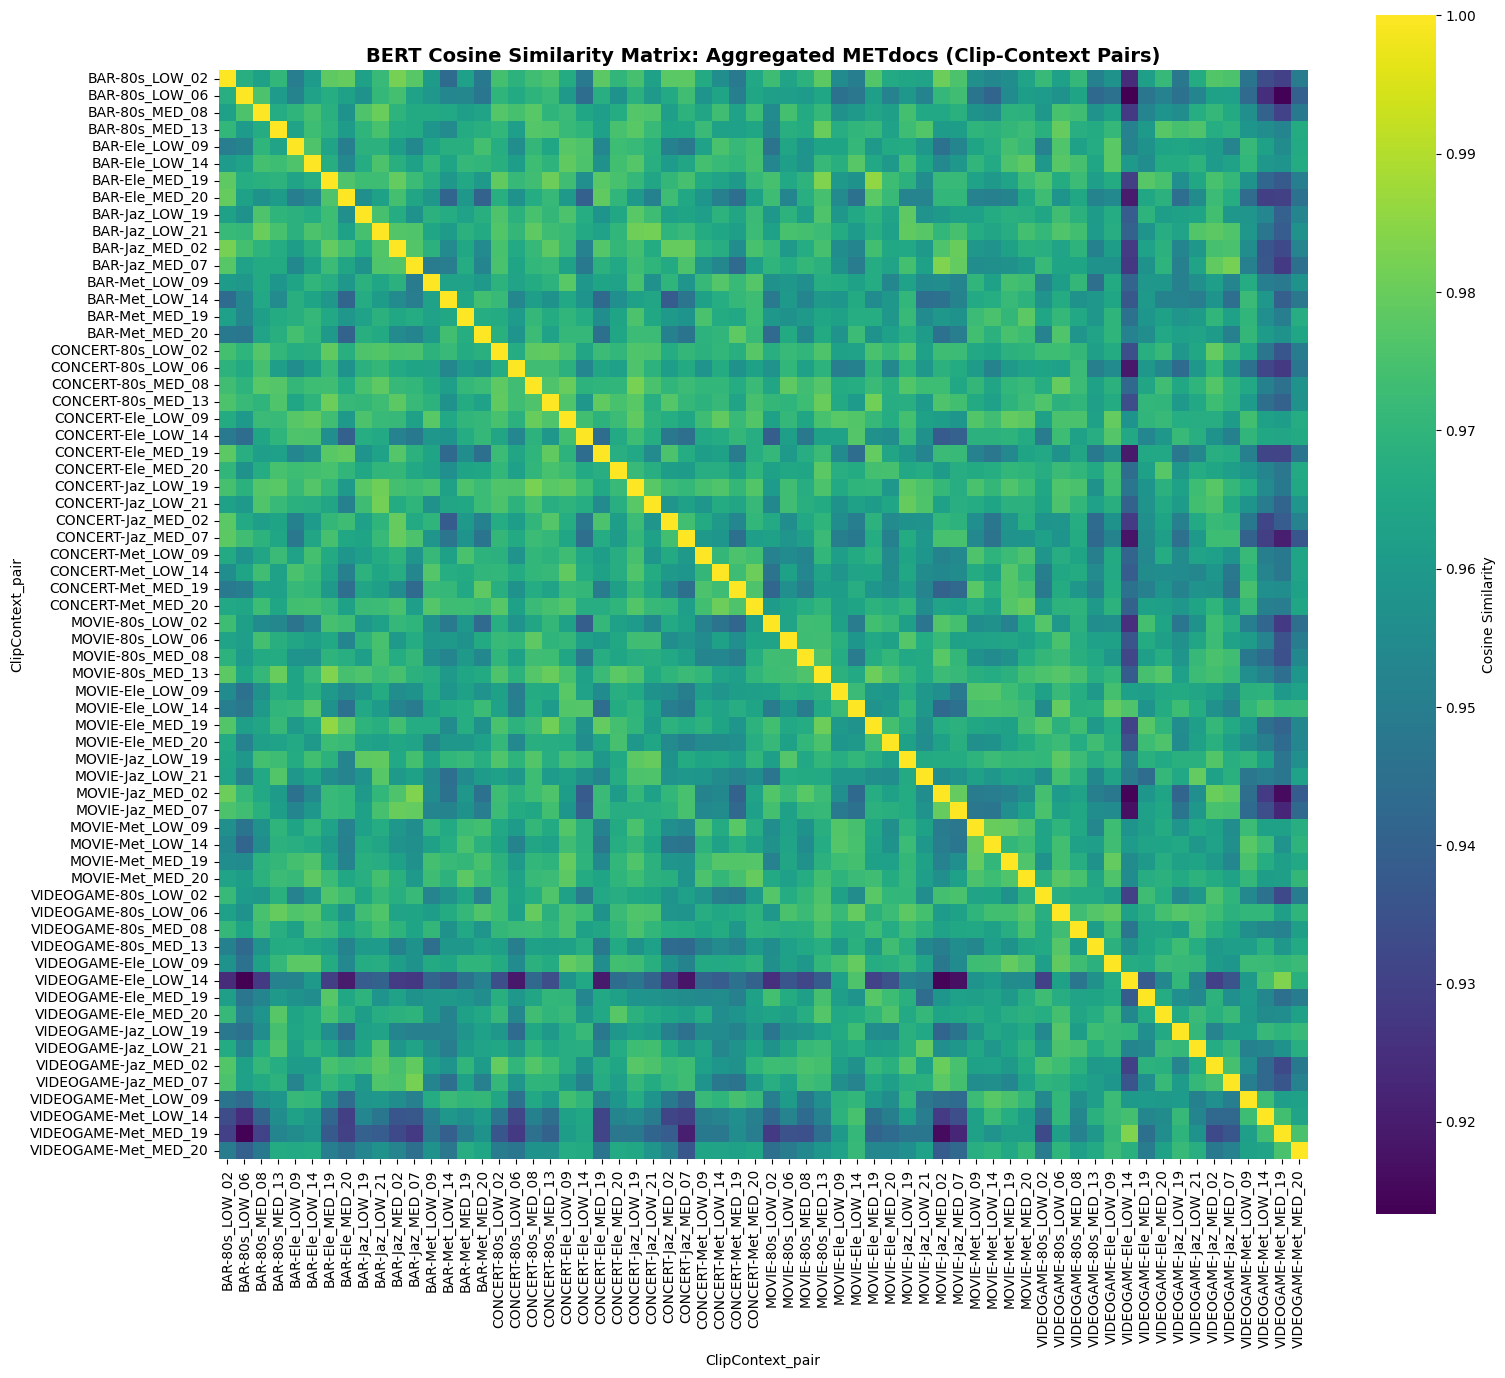

In [13]:
print("\nCalculating cosine similarity matrix...")
cosineMatrix_BERT = cosine_similarity(bert_embeddings, bert_embeddings)

# Create labeled DataFrame
cosineMatrix_BERT_df = pd.DataFrame(
    cosineMatrix_BERT,
    index=METdocs['ClipContext_pair'],
    columns=METdocs['ClipContext_pair']
)

# Save cosine similarity matrix
cosineMatrix_BERT_df.to_csv('/content/context-framed-listening/NLP_outputs/BERT/METdocs_cosineMatrix_BERT.csv',
                             encoding='utf-8')

print("\nBERT Cosine Similarity Matrix (METdocs level):")
display(cosineMatrix_BERT_df.head())

plt.figure(figsize=(16, 14))
sns.heatmap(cosineMatrix_BERT_df, cmap='viridis', annot=False, square=True,
            cbar_kws={'label': 'Cosine Similarity'})
plt.title('BERT Cosine Similarity Matrix: Aggregated METdocs (Clip-Context Pairs)',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/METdocs_heatmap_BERT.png',
            dpi=300, bbox_inches='tight')
plt.show()

### Similarity Values

In [14]:
print("\nExtracting similarity values by condition...")
print("Using IDENTICAL conditions as individual thought-level analysis...")

# Extract metadata
clips = METdocs['clip_name'].values
contexts = METdocs['context_word'].values
genres = METdocs['genre_code'].values

# Initialise storage for similarity measures
similarity_data = {
    'doc_i': [],
    'doc_j': [],
    'similarity': [],
    'same_clip': [],
    'same_context': [],
    'same_genre': [],
    'condition': []
}

# Iterate through upper triangle of similarity matrix
n_docs = len(METdocs)
print(f"Processing {(n_docs * (n_docs - 1)) // 2} unique document pairs...")

for i in range(n_docs):
    if (i + 1) % 10 == 0:
        print(f"  Processed {i + 1}/{n_docs} documents...")

    for j in range(i + 1, n_docs):
        # Extract similarity value
        sim_value = cosineMatrix_BERT[i, j]

        # Determine conditions (IDENTICAL to individual-level analysis)
        same_clip = clips[i] == clips[j]
        same_context = contexts[i] == contexts[j]
        same_genre = genres[i] == genres[j]

        # Categorise into SAME conditions as individual thought analysis
        if same_clip and same_context:
            condition = 'same_clip_same_context'
        elif same_clip and not same_context:
            condition = 'same_clip_diff_context'  # MUSIC influence
        elif not same_clip and same_context:
            condition = 'diff_clip_same_context'  # CONTEXT influence
        elif not same_clip and not same_context:
            if same_genre:
                condition = 'diff_clip_diff_context_same_genre'
            else:
                condition = 'diff_clip_diff_context_diff_genre'

        # Store data
        similarity_data['doc_i'].append(i)
        similarity_data['doc_j'].append(j)
        similarity_data['similarity'].append(sim_value)
        similarity_data['same_clip'].append(same_clip)
        similarity_data['same_context'].append(same_context)
        similarity_data['same_genre'].append(same_genre)
        similarity_data['condition'].append(condition)

# Create DataFrame
sim_df = pd.DataFrame(similarity_data)
sim_df.to_csv('/content/context-framed-listening/NLP_outputs/BERT/METdocs_similarity_by_condition_BERT.csv',
              index=False)

print("\nMETdocs-level similarity measures extracted:")
print(sim_df.groupby('condition')['similarity'].agg(['count', 'mean', 'std', 'min', 'max']))



Extracting similarity values by condition...
Using IDENTICAL conditions as individual thought-level analysis...
Processing 2016 unique document pairs...
  Processed 10/64 documents...
  Processed 20/64 documents...
  Processed 30/64 documents...
  Processed 40/64 documents...
  Processed 50/64 documents...
  Processed 60/64 documents...

METdocs-level similarity measures extracted:
                                   count      mean       std       min  \
condition                                                                
diff_clip_diff_context_diff_genre   1152  0.961045  0.011055  0.913324   
diff_clip_diff_context_same_genre    288  0.965767  0.010162  0.919224   
diff_clip_same_context               480  0.965126  0.009243  0.929710   
same_clip_diff_context                96  0.971750  0.006827  0.950220   

                                        max  
condition                                    
diff_clip_diff_context_diff_genre  0.983408  
diff_clip_diff_context_same_gen

### STATISTICAL ANALYSES

1. PRIMARY RESEARCH QUESTION: Music vs Context Influence
2. Genre Effects
3. Context Specificity
4. Music Specificity
5. BASELINE COMPARISON: Total shared features
6. OMNIBUS TEST: Overall condition differences
7. Effect Size Ranking

In [15]:
def compare_conditions(df, cond1, cond2, label1, label2):
    """Compare two conditions with t-test and effect size."""
    data1 = df[df['condition'] == cond1]['similarity']
    data2 = df[df['condition'] == cond2]['similarity']

    t_stat, p_value = stats.ttest_ind(data1, data2)

    # Cohen's d
    pooled_std = np.sqrt((data1.std()**2 + data2.std()**2) / 2)
    effect_size = (data1.mean() - data2.mean()) / pooled_std

    if p_value < 0.001:
        sig_str = "***"
    elif p_value < 0.01:
        sig_str = "**"
    elif p_value < 0.05:
        sig_str = "*"
    else:
        sig_str = "n.s."

    return {
        'comparison': f"{label1} vs {label2}",
        'mean1': data1.mean(),
        'mean2': data2.mean(),
        'diff': data1.mean() - data2.mean(),
        't': t_stat,
        'p': p_value,
        'sig': sig_str,
        'd': effect_size,
        'n1': len(data1),
        'n2': len(data2)
    }

# Store all comparison results
comparisons = []


# 1. PRIMARY RESEARCH QUESTION: Music vs Context Influence
# ----------------------------------------------------------------------------
print("\n1. PRIMARY QUESTION: Music vs Context Influence (METdocs level)")
print("-" * 70)

comp = compare_conditions(
    sim_df,
    'same_clip_diff_context',
    'diff_clip_same_context',
    'Same Music, Diff Context',
    'Diff Music, Same Context'
)
comparisons.append(comp)

print(f"\nSame music, different context: M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Different music, same context: M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"Difference: {comp['diff']:.4f}")
print(f"t({comp['n1'] + comp['n2'] - 2}) = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}")
print(f"Cohen's d = {comp['d']:.3f}")

if comp['mean1'] > comp['mean2']:
    print("\n→ At METdocs level: MUSIC drives similarity MORE than context")
else:
    print("\n→ At METdocs level: CONTEXT drives similarity MORE than music")


# 2. GENRE EFFECTS
# ----------------------------------------------------------------------------
print("\n\n2. GENRE EFFECTS (METdocs level)")
print("-" * 70)

comp = compare_conditions(
    sim_df,
    'diff_clip_diff_context_same_genre',
    'diff_clip_diff_context_diff_genre',
    'Different everything, Same Genre',
    'Different everything, Different Genre'
)
comparisons.append(comp)

print(f"\nSame genre (diff clip & context): M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Different genre (diff clip & context): M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"t = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}, d = {comp['d']:.3f}")

if comp['sig'] != 'n.s.':
    print("\n→ Genre creates semantic coherence at document level")
else:
    print("\n→ Genre does NOT significantly affect document-level similarity")


# 3. CONTEXT SPECIFICITY
# ----------------------------------------------------------------------------
print("\n\n3. CONTEXT SPECIFICITY (METdocs level)")
print("-" * 70)

comp = compare_conditions(
    sim_df,
    'same_clip_same_context',
    'diff_clip_same_context',
    'Same Context & Same Clip',
    'Same Context, Diff Clip'
)
comparisons.append(comp)

print(f"\nSame context + same clip: M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Same context, different clip: M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"t = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}, d = {comp['d']:.3f}")


# 4. MUSIC SPECIFICITY
# ----------------------------------------------------------------------------
print("\n\n4. MUSIC SPECIFICITY (METdocs level)")
print("-" * 70)

comp = compare_conditions(
    sim_df,
    'same_clip_same_context',
    'same_clip_diff_context',
    'Same Clip & Same Context',
    'Same Clip, Diff Context'
)
comparisons.append(comp)

print(f"\nSame clip + same context: M={comp['mean1']:.4f} (N={comp['n1']})")
print(f"Same clip, different context: M={comp['mean2']:.4f} (N={comp['n2']})")
print(f"t = {comp['t']:.3f}, p = {comp['p']:.4f} {comp['sig']}, d = {comp['d']:.3f}")


# 5. OMNIBUS TEST
# ----------------------------------------------------------------------------
print("\n\n5. OMNIBUS TEST: Do conditions differ overall? (METdocs level)")
print("-" * 70)

conditions = sim_df['condition'].unique()
groups = [sim_df[sim_df['condition'] == cond]['similarity'] for cond in conditions]
f_stat, p_anova = stats.f_oneway(*groups)

print(f"\nOne-way ANOVA across all {len(conditions)} conditions:")
print(f"F({len(conditions)-1}, {len(sim_df)-len(conditions)}) = {f_stat:.3f}, p = {p_anova:.4e}")

if p_anova < 0.001:
    print("\n→ Conditions are HIGHLY significantly different at document level")
else:
    print("\n→ Conditions show significant differences" if p_anova < 0.05 else "→ No significant differences")

# 6. EFFECT SIZE RANKING
# ----------------------------------------------------------------------------
print("\n\n6. CONDITION MEANS RANKING (METdocs level)")
print("-" * 70)

condition_means = sim_df.groupby('condition')['similarity'].agg(['mean', 'std', 'count'])
condition_means = condition_means.sort_values('mean', ascending=False)

print("\nCondition means (ranked):")
print(condition_means)

# Save comparison results
comparisons_df = pd.DataFrame(comparisons)
comparisons_df = comparisons_df.sort_values('d', key=abs, ascending=False)
comparisons_df.to_csv('/content/context-framed-listening/NLP_outputs/BERT/METdocs_statistical_comparisons_BERT.csv',
                      index=False)

print("\n\nKey comparisons ranked by effect size:")
print(comparisons_df[['comparison', 'diff', 'd', 'p', 'sig']])



1. PRIMARY QUESTION: Music vs Context Influence (METdocs level)
----------------------------------------------------------------------

Same music, different context: M=0.9718 (N=96)
Different music, same context: M=0.9651 (N=480)
Difference: 0.0066
t(574) = 6.666, p = 0.0000 ***
Cohen's d = 0.815

→ At METdocs level: MUSIC drives similarity MORE than context


2. GENRE EFFECTS (METdocs level)
----------------------------------------------------------------------

Same genre (diff clip & context): M=0.9658 (N=288)
Different genre (diff clip & context): M=0.9610 (N=1152)
t = 6.586, p = 0.0000 ***, d = 0.445

→ Genre creates semantic coherence at document level


3. CONTEXT SPECIFICITY (METdocs level)
----------------------------------------------------------------------

Same context + same clip: M=nan (N=0)
Same context, different clip: M=0.9651 (N=480)
t = nan, p = nan n.s., d = nan


4. MUSIC SPECIFICITY (METdocs level)
---------------------------------------------------------------

/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


### Visualisations

1. PRIMARY COMPARISON: Music vs Context
2. ALL CONDITIONS comparison
3. Bar plot with means and 95% CI
4. Distribution comparison histogram (Music vs Context)
5. HIERARCHICAL comparison showing all levels
6. Genre effects visualization
7. Heatmap showing mean similarities between conditions


Generating visualisations...


/tmp/ipython-input-3114623944.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Same Music\nDifferent Context', 'Different Music\nSame Context'])


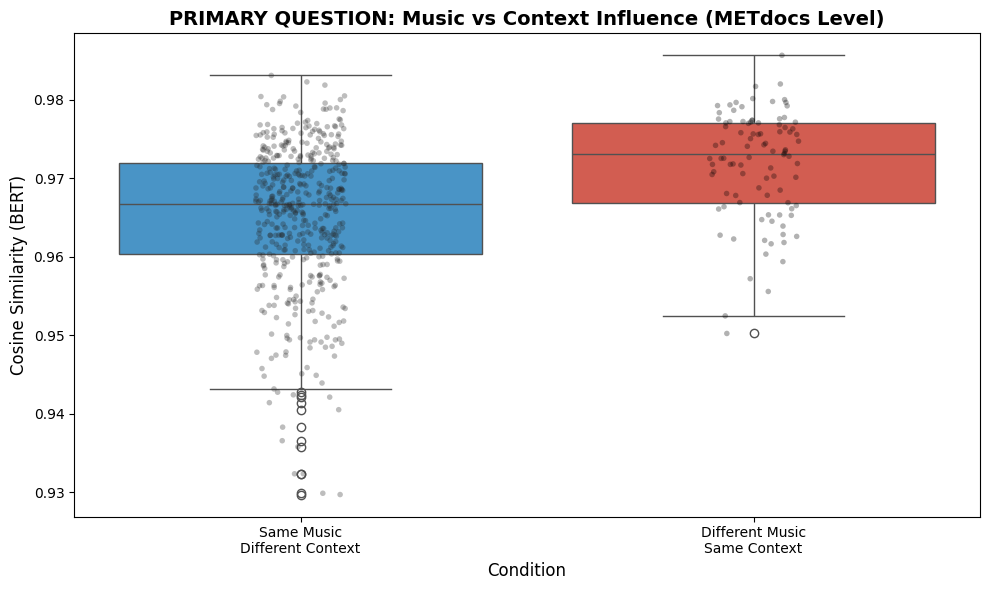

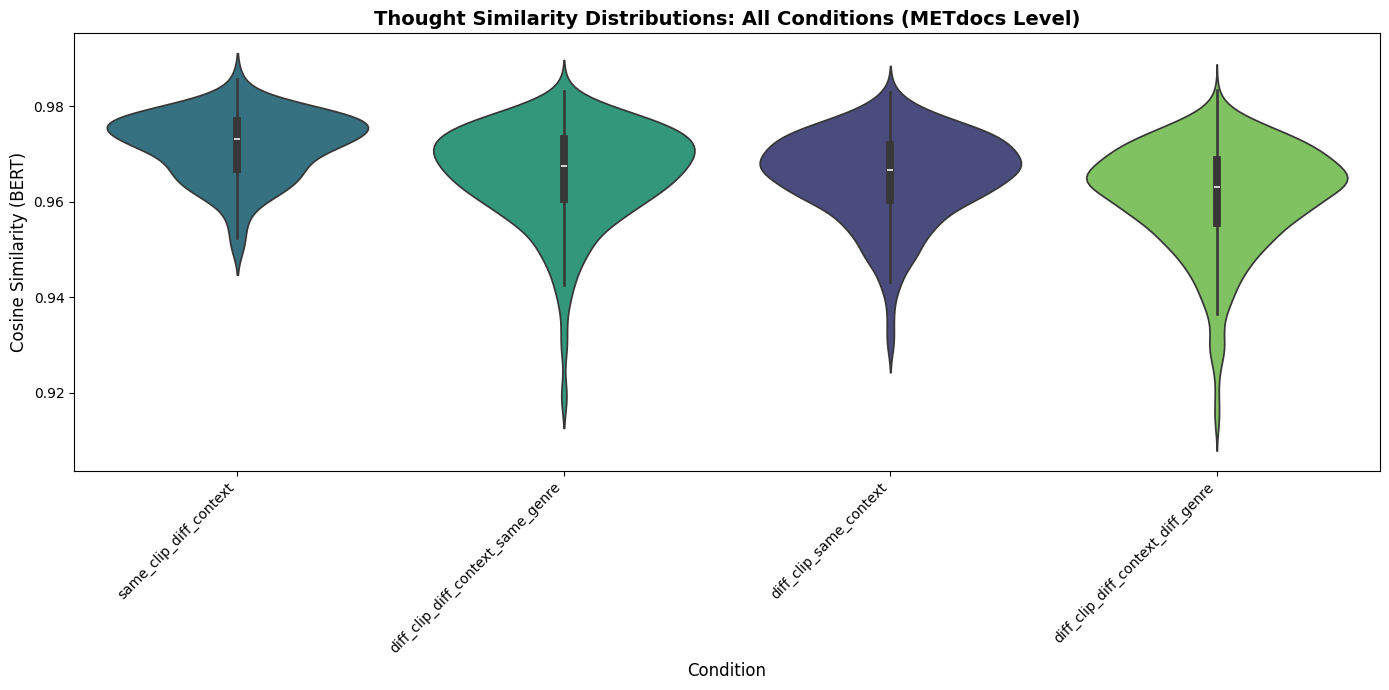

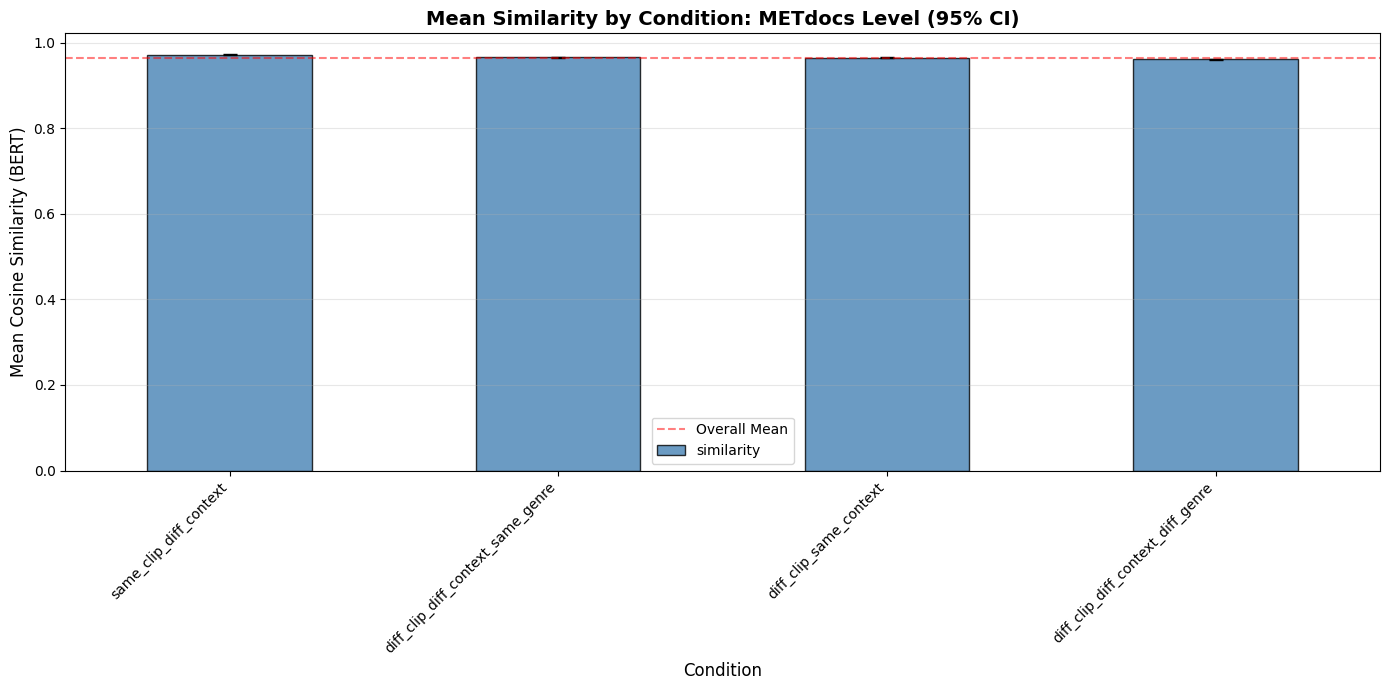

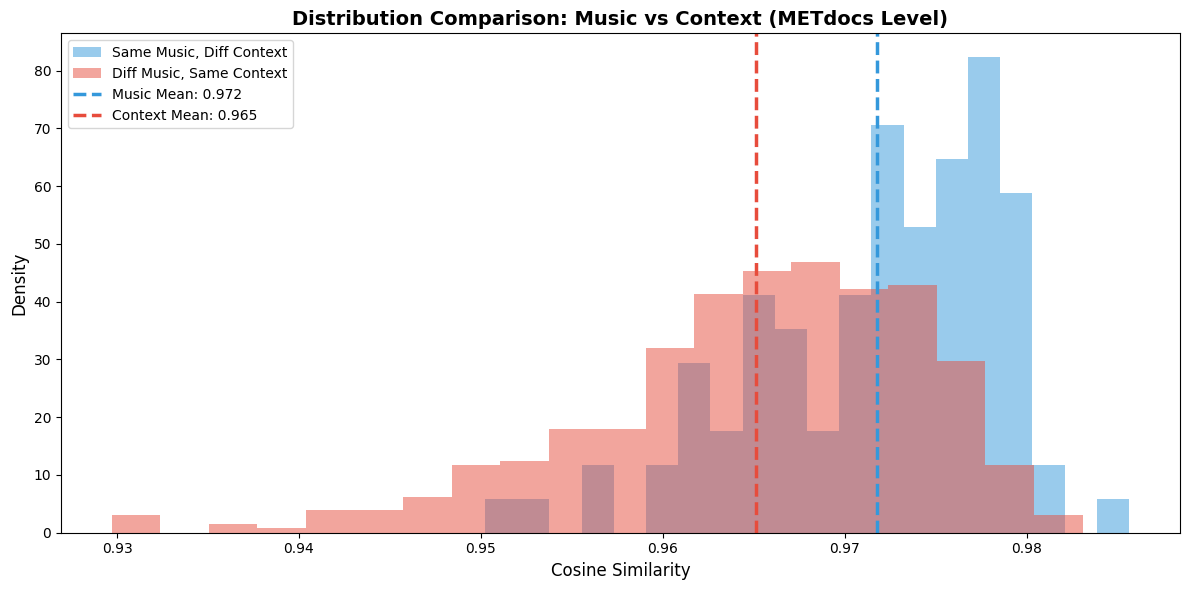

/tmp/ipython-input-3114623944.py:101: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=0, ha='center')


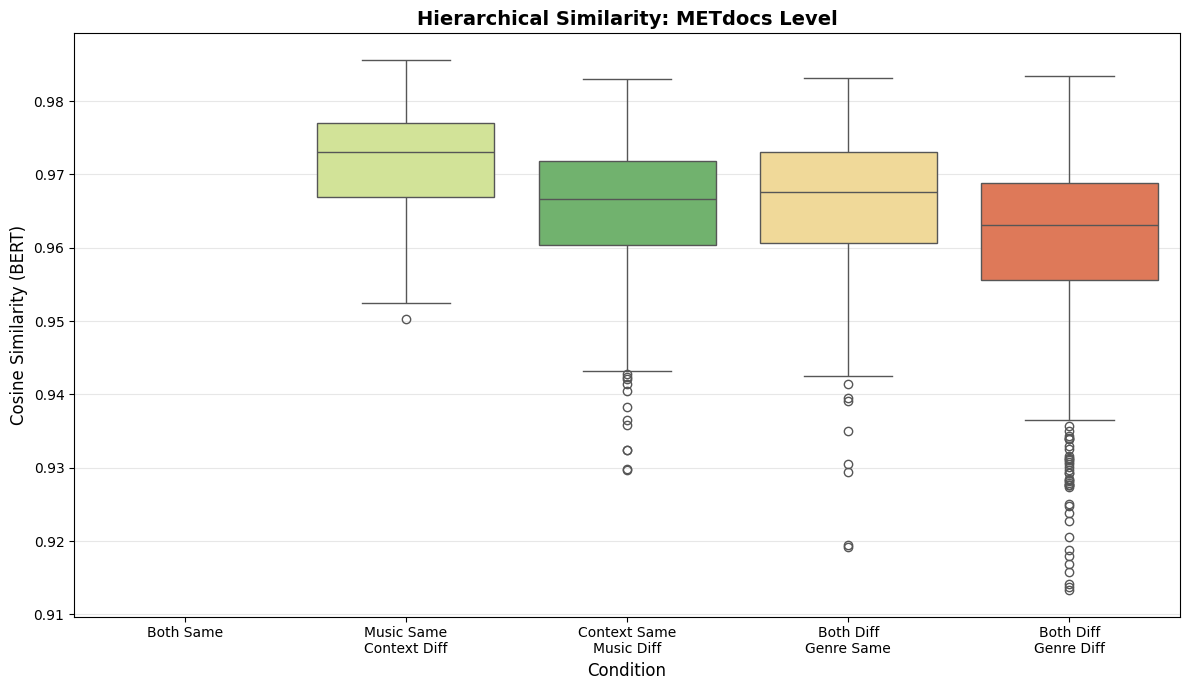

/tmp/ipython-input-3114623944.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Same Genre', 'Different Genre'])


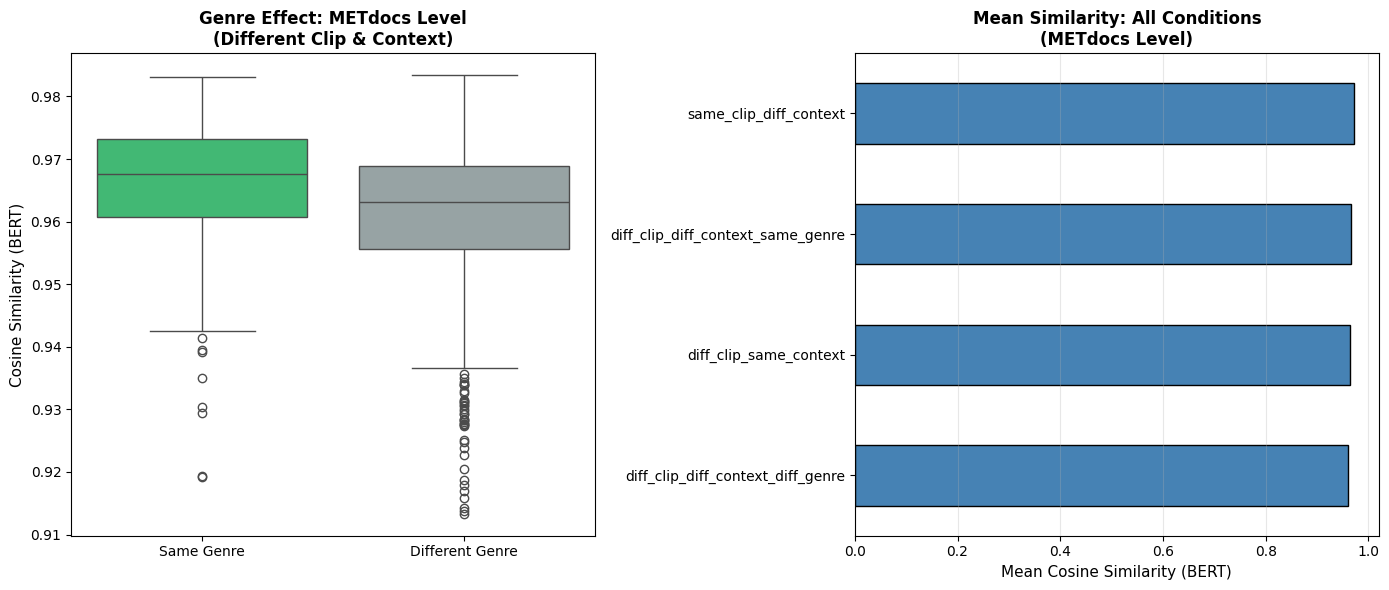

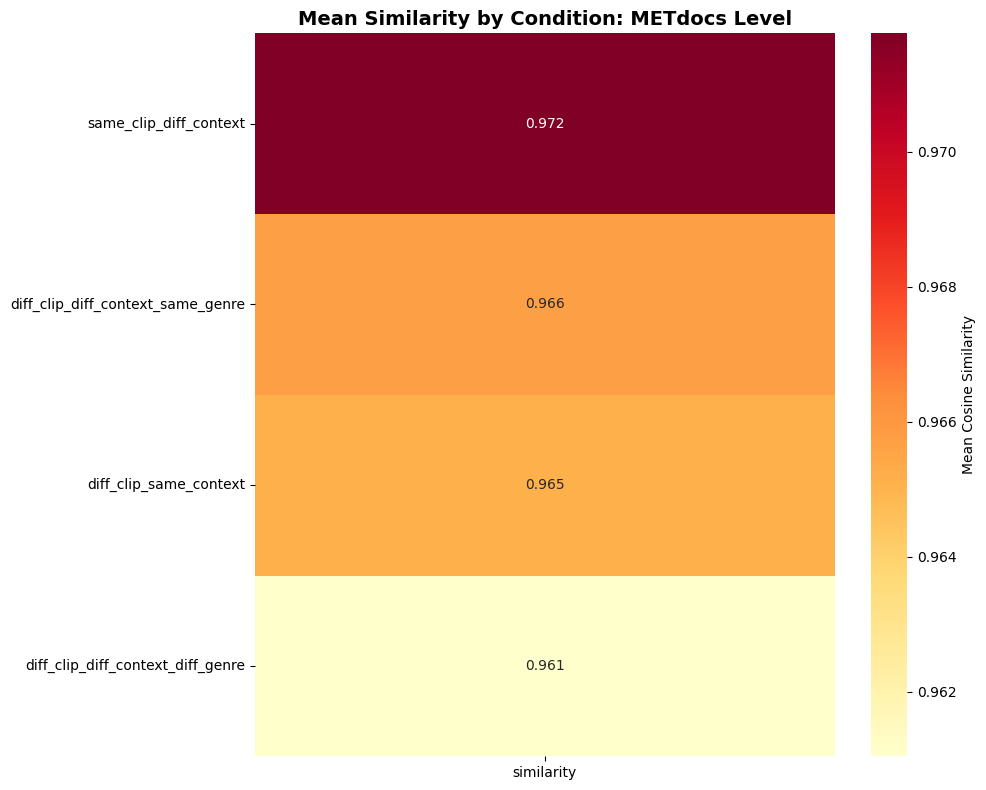

In [16]:
print("\nGenerating visualisations...")

# Get data for key conditions
music_driven = sim_df[sim_df['condition'] == 'same_clip_diff_context']['similarity']
context_driven = sim_df[sim_df['condition'] == 'diff_clip_same_context']['similarity']
same_both = sim_df[sim_df['condition'] == 'same_clip_same_context']['similarity']
diff_both_same_genre = sim_df[sim_df['condition'] == 'diff_clip_diff_context_same_genre']['similarity']
diff_both_diff_genre = sim_df[sim_df['condition'] == 'diff_clip_diff_context_diff_genre']['similarity']

# 1. PRIMARY COMPARISON: Music vs Context
fig, ax = plt.subplots(figsize=(10, 6))
comparison_data = sim_df[sim_df['condition'].isin(['same_clip_diff_context', 'diff_clip_same_context'])]
sns.boxplot(data=comparison_data, x='condition', y='similarity', ax=ax,
            hue='condition', palette=['#3498db', '#e74c3c'])
sns.stripplot(data=comparison_data, x='condition', y='similarity', ax=ax,
              hue='condition', palette='dark:black', alpha=0.3, size=4)
ax.set_title('PRIMARY QUESTION: Music vs Context Influence (METdocs Level)',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Cosine Similarity (BERT)', fontsize=12)
ax.set_xticklabels(['Same Music\nDifferent Context', 'Different Music\nSame Context'])
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/METdocs_01_music_vs_context_boxplot_BERT.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 2. ALL CONDITIONS comparison
fig, ax = plt.subplots(figsize=(14, 7))
condition_order = sim_df.groupby('condition')['similarity'].mean().sort_values(ascending=False).index
sns.violinplot(data=sim_df, x='condition', y='similarity', ax=ax, order=condition_order,
               hue='condition', palette='viridis')
ax.set_title('Thought Similarity Distributions: All Conditions (METdocs Level)',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Cosine Similarity (BERT)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/METdocs_02_all_conditions_violin_BERT.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 3. Bar plot with means and 95% CI
fig, ax = plt.subplots(figsize=(14, 7))
means = sim_df.groupby('condition')['similarity'].mean().sort_values(ascending=False)
sems = sim_df.groupby('condition')['similarity'].sem()
ci95 = sems * 1.96

means.plot(kind='bar', ax=ax, yerr=ci95, capsize=5, color='steelblue',
           edgecolor='black', alpha=0.8, error_kw={'linewidth': 2})
ax.set_title('Mean Similarity by Condition: METdocs Level (95% CI)',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Mean Cosine Similarity (BERT)', fontsize=12)
ax.set_xticklabels(means.index, rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=sim_df['similarity'].mean(), color='red', linestyle='--',
           alpha=0.5, label='Overall Mean')
ax.legend()
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/METdocs_03_condition_means_barplot_BERT.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 4. Distribution comparison histogram (Music vs Context)
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(music_driven, bins=20, alpha=0.5, label='Same Music, Diff Context',
        color='#3498db', density=True)
ax.hist(context_driven, bins=20, alpha=0.5, label='Diff Music, Same Context',
        color='#e74c3c', density=True)
ax.axvline(music_driven.mean(), color='#3498db', linestyle='--', linewidth=2.5,
           label=f'Music Mean: {music_driven.mean():.3f}')
ax.axvline(context_driven.mean(), color='#e74c3c', linestyle='--', linewidth=2.5,
           label=f'Context Mean: {context_driven.mean():.3f}')
ax.set_xlabel('Cosine Similarity', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Distribution Comparison: Music vs Context (METdocs Level)',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/METdocs_04_music_vs_context_histogram_BERT.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 5. HIERARCHICAL comparison showing all levels
fig, ax = plt.subplots(figsize=(12, 7))
hierarchical_data = sim_df[sim_df['condition'].isin([
    'same_clip_same_context',
    'same_clip_diff_context',
    'diff_clip_same_context',
    'diff_clip_diff_context_same_genre',
    'diff_clip_diff_context_diff_genre'
])]

order = ['same_clip_same_context', 'same_clip_diff_context', 'diff_clip_same_context',
         'diff_clip_diff_context_same_genre', 'diff_clip_diff_context_diff_genre']
labels = ['Both Same', 'Music Same\nContext Diff', 'Context Same\nMusic Diff',
          'Both Diff\nGenre Same', 'Both Diff\nGenre Diff']

sns.boxplot(data=hierarchical_data, x='condition', y='similarity', ax=ax,
            order=order, hue='condition', palette='RdYlGn_r')
ax.set_xticklabels(labels, rotation=0, ha='center')
ax.set_title('Hierarchical Similarity: METdocs Level', fontsize=14, fontweight='bold')
ax.set_xlabel('Condition', fontsize=12)
ax.set_ylabel('Cosine Similarity (BERT)', fontsize=12)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/METdocs_05_hierarchical_comparison_BERT.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 6. Genre effects visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Genre effect when everything else differs
genre_comparison = sim_df[sim_df['condition'].isin([
    'diff_clip_diff_context_same_genre',
    'diff_clip_diff_context_diff_genre'
])]
sns.boxplot(data=genre_comparison, x='condition', y='similarity', ax=axes[0],
            hue='condition', palette=['#2ecc71', '#95a5a6'])
axes[0].set_title('Genre Effect: METdocs Level\n(Different Clip & Context)',
                  fontsize=12, fontweight='bold')
axes[0].set_xticklabels(['Same Genre', 'Different Genre'])
axes[0].set_ylabel('Cosine Similarity (BERT)', fontsize=11)
axes[0].set_xlabel('')

# Show all conditions side by side
all_conditions_means = sim_df.groupby('condition')['similarity'].mean()
all_conditions_means.sort_values(ascending=True).plot(kind='barh', ax=axes[1],
                                                       color='steelblue', edgecolor='black')
axes[1].set_title('Mean Similarity: All Conditions\n(METdocs Level)',
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('Mean Cosine Similarity (BERT)', fontsize=11)
axes[1].set_ylabel('')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/METdocs_06_genre_effects_summary_BERT.png',
            dpi=300, bbox_inches='tight')
plt.show()

# 7. Heatmap showing mean similarities between conditions
fig, ax = plt.subplots(figsize=(10, 8))
condition_pivot = sim_df.pivot_table(values='similarity',
                                      index='condition',
                                      aggfunc='mean').sort_values('similarity', ascending=False)
sns.heatmap(condition_pivot, annot=True, fmt='.3f', cmap='YlOrRd',
            cbar_kws={'label': 'Mean Cosine Similarity'}, ax=ax)
ax.set_title('Mean Similarity by Condition: METdocs Level', fontsize=14, fontweight='bold')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig('/content/context-framed-listening/NLP_outputs/BERT/METdocs_07_condition_heatmap_BERT.png',
            dpi=300, bbox_inches='tight')
plt.show()

### SUMMARY

In [17]:
print("\n" + "-"*70)
print("METDOCS-LEVEL ANALYSIS COMPLETE")
print("-"*70)

print("\nOutput files saved:")
print("  Data files:")
print("    - METdocs_embeddings_BERT.npy")
print("    - METdocs_cosineMatrix_BERT.csv")
print("    - METdocs_similarity_by_condition_BERT.csv")
print("    - METdocs_statistical_comparisons_BERT.csv")

print("\n  Visualisations:")
print("    - METdocs_heatmap_BERT.png")
print("    - METdocs_01_music_vs_context_boxplot_BERT.png")
print("    - METdocs_02_all_conditions_violin_BERT.png")
print("    - METdocs_03_condition_means_barplot_BERT.png")
print("    - METdocs_04_music_vs_context_histogram_BERT.png")
print("    - METdocs_05_hierarchical_comparison_BERT.png")
print("    - METdocs_06_genre_effects_summary_BERT.png")
print("    - METdocs_07_condition_heatmap_BERT.png")

print("\n" + "-"*70)
print("KEY FINDINGS SUMMARY (METdocs Level)")
print("-"*70)

# Get the primary comparison again for summary
music_driven_summary = sim_df[sim_df['condition'] == 'same_clip_diff_context']['similarity']
context_driven_summary = sim_df[sim_df['condition'] == 'diff_clip_same_context']['similarity']
diff = music_driven_summary.mean() - context_driven_summary.mean()
t_stat, p_value = stats.ttest_ind(music_driven_summary, context_driven_summary)
effect_size = diff / np.sqrt((music_driven_summary.std()**2 + context_driven_summary.std()**2) / 2)

print("\n1. PRIMARY RESEARCH QUESTION: Music vs Context (METdocs level)")
if abs(diff) < 0.01:
    print(f"   → Music and context have EQUIVALENT influence (d={effect_size:.3f})")
elif music_driven_summary.mean() > context_driven_summary.mean():
    print(f"   → MUSIC drives similarity MORE than context")
    print(f"   → Difference: {diff:.4f} (d={effect_size:.3f}, p={p_value:.4f})")
else:
    print(f"   → CONTEXT drives similarity MORE than music")
    print(f"   → Difference: {abs(diff):.4f} (d={abs(effect_size):.3f}, p={p_value:.4f})")

# Genre effects
same_genre = sim_df[sim_df['condition'] == 'diff_clip_diff_context_same_genre']['similarity'].mean()
diff_genre = sim_df[sim_df['condition'] == 'diff_clip_diff_context_diff_genre']['similarity'].mean()
print(f"\n2. GENRE EFFECTS (METdocs level)")
print(f"   → Same genre: M={same_genre:.4f}")
print(f"   → Different genre: M={diff_genre:.4f}")
print(f"   → Difference: {same_genre - diff_genre:.4f}")

# Baseline
if len(same_both) > 0:
    print(f"\n3. BASELINE (identical clip-context pairs)")
    print(f"   → Note: Same clip + same context = same document (N={len(same_both)})")
    print(f"   → Mean similarity: {same_both.mean():.4f}")

print("\n" + "-"*70)
print("COMPARISON NOTE:")
print("-"*70)
print("This METdocs analysis uses IDENTICAL condition categories as the")
print("individual thought-level analysis, enabling direct comparison of:")
print("  - Effect sizes (Cohen's d)")
print("  - Condition rankings")
print("  - Statistical significance patterns")
print("\nKey differences:")
print("  - METdocs: N documents = ~64 (clip-context pairs)")
print("  - Individual: N pairs = ~1.9 million (all thought pairs)")
print("  - METdocs: Shows condition-level semantic profiles")
print("  - Individual: Shows individual-level variability and patterns")
print("\nUse both analyses together to understand patterns at different scales")
print("~"*70)


----------------------------------------------------------------------
METDOCS-LEVEL ANALYSIS COMPLETE
----------------------------------------------------------------------

Output files saved:
  Data files:
    - METdocs_embeddings_BERT.npy
    - METdocs_cosineMatrix_BERT.csv
    - METdocs_similarity_by_condition_BERT.csv
    - METdocs_statistical_comparisons_BERT.csv

  Visualisations:
    - METdocs_heatmap_BERT.png
    - METdocs_01_music_vs_context_boxplot_BERT.png
    - METdocs_02_all_conditions_violin_BERT.png
    - METdocs_03_condition_means_barplot_BERT.png
    - METdocs_04_music_vs_context_histogram_BERT.png
    - METdocs_05_hierarchical_comparison_BERT.png
    - METdocs_06_genre_effects_summary_BERT.png
    - METdocs_07_condition_heatmap_BERT.png

----------------------------------------------------------------------
KEY FINDINGS SUMMARY (METdocs Level)
----------------------------------------------------------------------

1. PRIMARY RESEARCH QUESTION: Music vs Context (MET